In [1]:
# Install dependencies
!pip install kaggle timm torchvision matplotlib scikit-learn seaborn --quiet

# Step 1: Upload Kaggle API Key
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json here

import os, zipfile
kaggle_json = list(uploaded.keys())[0]
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"
os.makedirs(os.environ['KAGGLE_CONFIG_DIR'], exist_ok=True)
os.rename(kaggle_json, f"{os.environ['KAGGLE_CONFIG_DIR']}/kaggle.json")

# Step 2: Download and Extract PlantVillage dataset
!kaggle datasets download -d emmarex/plantdisease
with zipfile.ZipFile("plantdisease.zip", 'r') as zip_ref:
    zip_ref.extractall("PlantVillage")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 87% 569M/658M [00:03<00:01, 51.9MB/s]
100% 658M/658M [00:03<00:00, 189MB/s] 


In [2]:
# Step 3: Organize dataset into train/val/test
import shutil, os, random
from collections import defaultdict

base_dir = "PlantVillage/PlantVillage"
output_dirs = ['train', 'val', 'test']

for d in output_dirs:
    for cls in os.listdir(base_dir):
        os.makedirs(os.path.join(d, cls), exist_ok=True)

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)
    n = len(images)
    n_train, n_val = int(0.8 * n), int(0.1 * n)

    for i, img in enumerate(images):
        src = os.path.join(cls_path, img)
        if i < n_train:
            dst = os.path.join('train', cls, img)
        elif i < n_train + n_val:
            dst = os.path.join('val', cls, img)
        else:
            dst = os.path.join('test', cls, img)
        shutil.copyfile(src, dst)

In [3]:
# Step 4: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Step 5: Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("train", transform=transform)
val_data = datasets.ImageFolder("val", transform=transform)
test_data = datasets.ImageFolder("test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
num_classes = len(class_names)

In [5]:
# Step 6: Load Swin Transformer
model = create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=num_classes,
    global_pool='avg'
)
model.to(device)

# Freeze backbone, train only classifier head
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [6]:
# Step 7: Train
train_losses, val_losses, train_accs, val_accs = [], [], [], []
start = time.time()
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(total_loss / len(train_loader.dataset))
    train_accs.append(correct / len(train_loader.dataset))

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accs.append(val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

end = time.time()
training_time = end - start

Epoch 1/10 | Train Acc: 0.5597 | Val Acc: 0.7434
Epoch 2/10 | Train Acc: 0.7884 | Val Acc: 0.8362
Epoch 3/10 | Train Acc: 0.8431 | Val Acc: 0.8693
Epoch 4/10 | Train Acc: 0.8712 | Val Acc: 0.8834
Epoch 5/10 | Train Acc: 0.8894 | Val Acc: 0.8950
Epoch 6/10 | Train Acc: 0.8981 | Val Acc: 0.9028
Epoch 7/10 | Train Acc: 0.9091 | Val Acc: 0.9150
Epoch 8/10 | Train Acc: 0.9155 | Val Acc: 0.9155
Epoch 9/10 | Train Acc: 0.9183 | Val Acc: 0.9261
Epoch 10/10 | Train Acc: 0.9267 | Val Acc: 0.9257


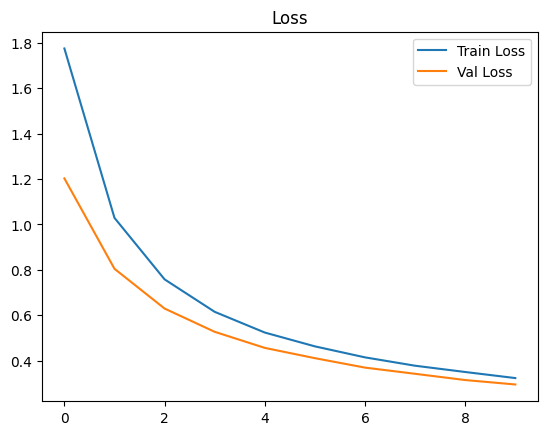

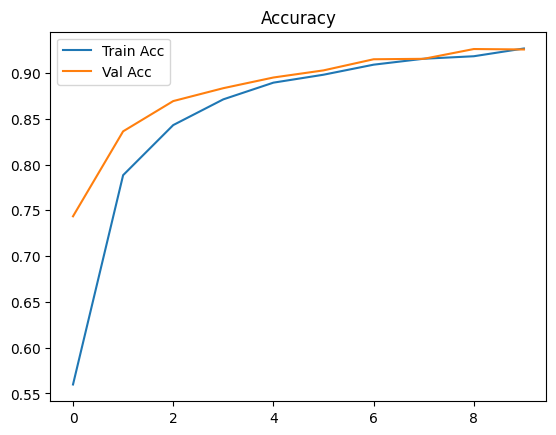

In [7]:
# Step 8: Loss and Accuracy Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [8]:
# Step 9: Test Evaluation
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_probs.extend(outputs.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")


✅ Test Accuracy: 93.21%



📊 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.96      0.98       101
                     Pepper__bell___healthy       0.97      0.99      0.98       149
                      Potato___Early_blight       0.98      0.97      0.97       100
                       Potato___Late_blight       0.93      0.93      0.93       100
                           Potato___healthy       0.93      0.81      0.87        16
                      Tomato_Bacterial_spot       0.91      0.94      0.93       214
                        Tomato_Early_blight       0.86      0.68      0.76       100
                         Tomato_Late_blight       0.91      0.92      0.91       192
                           Tomato_Leaf_Mold       0.97      0.88      0.92        96
                  Tomato_Septoria_leaf_spot       0.90      0.90      0.90       178
Tomato_Spider_mites_Two_spotted_spider

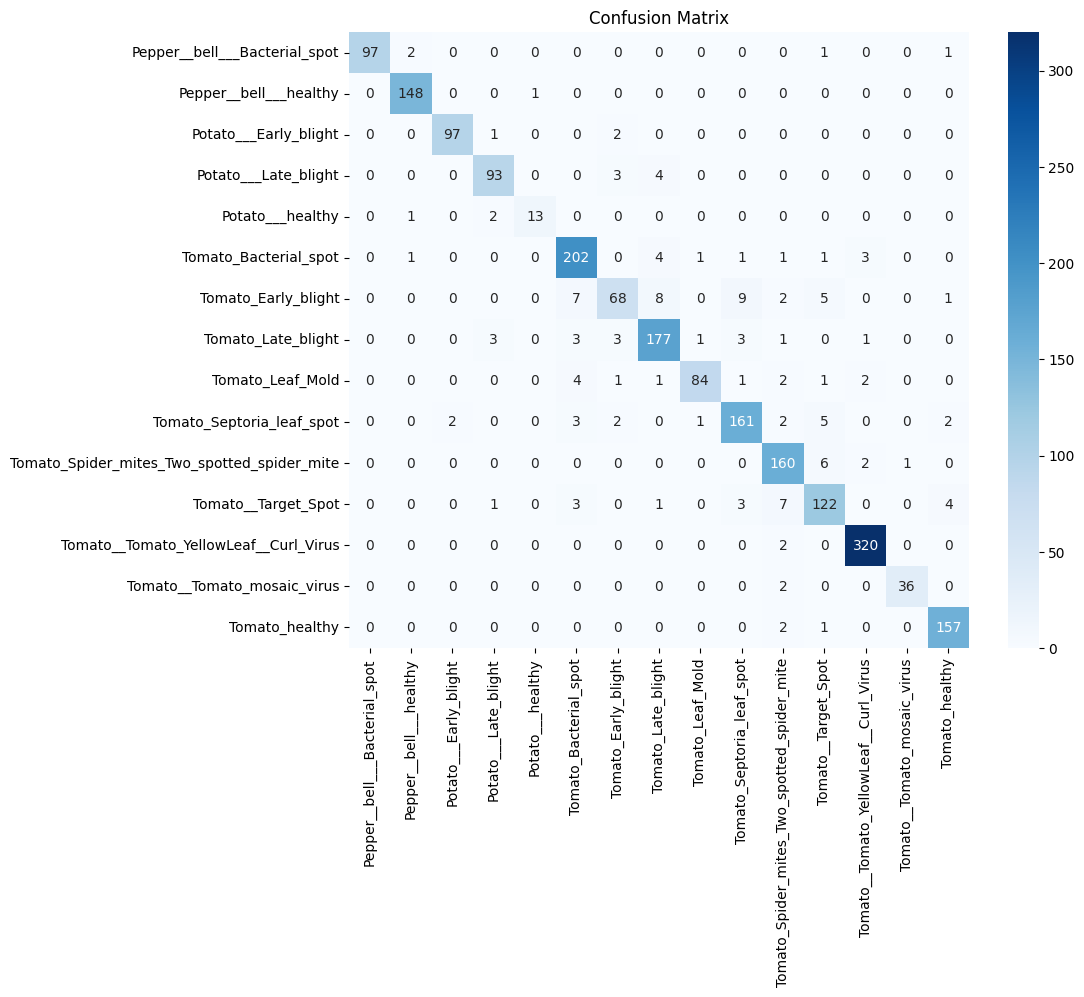

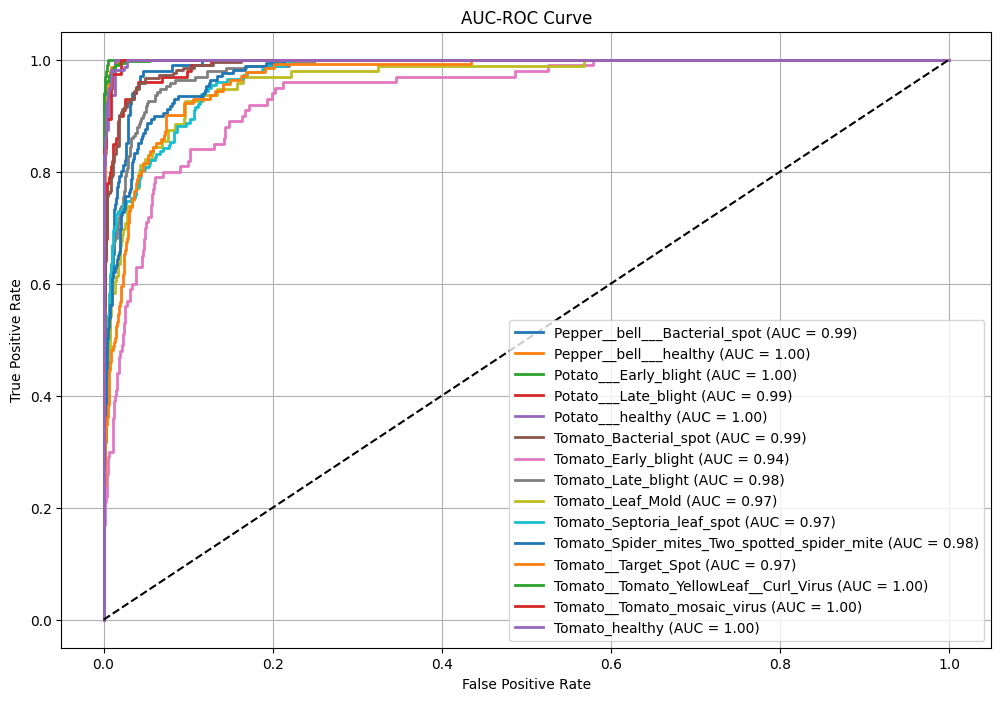

🧮 Macro AUC: 0.9848
🧮 Weighted AUC: 0.9854


In [9]:
# Step 10: Metrics
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_probs = np.array(y_probs)

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print(f"🧮 Macro AUC: {roc_auc_score(y_true_bin, y_probs, average='macro'):.4f}")
print(f"🧮 Weighted AUC: {roc_auc_score(y_true_bin, y_probs, average='weighted'):.4f}")

In [10]:
# Step 11: Summary
model_size_MB = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)
print(f"\n⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")
print(f"✅ Final Train Accuracy: {train_accs[-1] * 100:.2f}%")
print(f"✅ Final Val Accuracy: {val_accs[-1] * 100:.2f}%")



⏱️ Training Time: 1260.86 seconds
📦 Model Size: 105.02 MB
✅ Final Train Accuracy: 92.67%
✅ Final Val Accuracy: 92.57%
